In [2]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import os
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [4]:
def get_images(path, transforms=None):
    images = []
    image_path = os.listdir(path)
    file_paths = [os.path.join(path,f) for f in image_path]
    for path in file_paths:
        # print(path)
        image = Image.open(path).convert("RGB")
        if transforms:
            image = transforms(image)
        images.append(image)
    return images

training_path = "/kaggle/input/aiml-project/train_images_500"
Transform = transforms.Compose([transforms.Resize((256,256)),
                        transforms.ToTensor()])


training_images = get_images(training_path)

In [5]:
validation_path = "/kaggle/input/aiml-project/validation_images_100"
Transform = transforms.Compose([transforms.Resize((256,256)),
                        transforms.ToTensor()])

validation_images = get_images(validation_path)

In [6]:
GAUSSIAN = "gaussian"

In [7]:
#Image Transformations for the data augmentation
img_transform = {
    'original':transforms.Compose([
        transforms.ToTensor(),                            
        transforms.Resize((256, 256)),
    ]),
    'hflip': transforms.Compose([
        transforms.RandomHorizontalFlip(p=1),
        transforms.ToTensor(),                            
        transforms.Resize((256, 256)),
]),
    'rotation':transforms.Compose([          
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),                            
        transforms.Resize((256, 256)),
]),
    'crop':transforms.Compose([
        transforms.RandomCrop(size=(256, 256)),            # Randomly crop the image to the specified size    
        transforms.ToTensor()
])
}

In [8]:
def addNoise(img, noise_type, param):
    if noise_type == GAUSSIAN:
        minval,maxval = param
        stddev = np.random.uniform(minval, maxval) / maxval     # scaling the std. deviation also between 0 and 1
        noise = torch.randn(img.shape) * stddev                 # Zero Mean Noise
        noise_img = img + noise
        noise_img = torch.clip(noise_img, min=-0.5, max=0.5)
        return noise_img

In [9]:
class customDataset(Dataset):
    def __init__(self, data, noise_type,  noise_params, noise_func, transform=None, ):
        self.data = []
        self.transform = transform
        self.noise_type = noise_type
        self.noise_param = noise_params
        self.noise_func = noise_func
        for trans in transform.keys():
            self.data.extend([(ele, trans) for ele in data])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        img =  sample[0]
        img = self.transform[sample[1]](img)
        
        x = self.noise_func(img, self.noise_type, self.noise_param) 
        y = self.noise_func(img, self.noise_type, self.noise_param)
        return x,y

In [10]:
train_dataset = customDataset(training_images, GAUSSIAN, (0,50), addNoise, img_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle = True)
valid_dataset = customDataset(validation_images, GAUSSIAN, (0,50), addNoise, {"original":img_transform['original']})
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle = False)

In [11]:
len(train_dataset), len(train_loader), len(train_loader)*2, len(valid_dataset), len(valid_loader)

(2000, 63, 126, 100, 7)

16 16
torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
(256, 256, 3)
Check


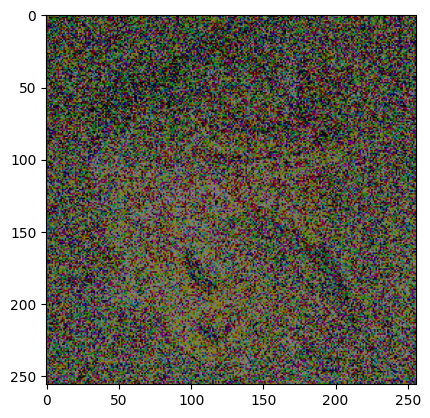

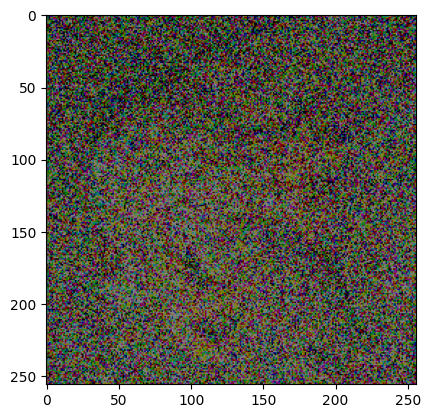

16 16
torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
(256, 256, 3)
Check


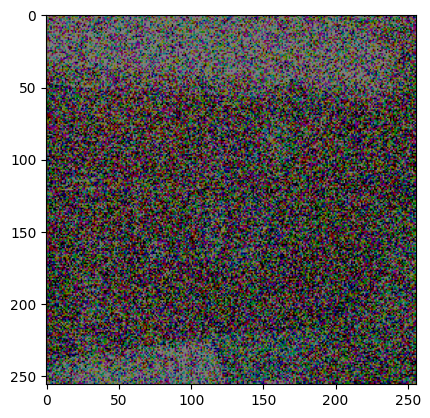

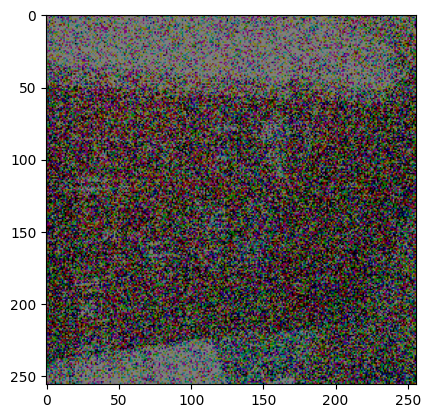

In [12]:
count = 1
for x,y in valid_loader:
    print(len(x), len(y))
    print(x[0].shape, y[0].shape)

    img = x[0].numpy()
    img1 = y[0].numpy()
    # print(type(img))
    # img = img.reshape([img.shape[1], img.shape[2], img.shape[0]])
    img = img.T
    print(img.shape)
    print("Check")
    plt.imshow(img)
    plt.show()
    # plt.imshow(img1.reshape([img1.shape[1], img1.shape[2], img1.shape[0]]))
    plt.imshow(img1.T)
    plt.show()
    if count ==2:
        break
    count += 1

In [14]:
class UNet(nn.Module):
    
    def __init__(self):
        super(UNet, self).__init__()
                
        self.conv0 = nn.Conv2d(3,48,3,padding=1)
        self.conv1 = nn.Conv2d(48,48,3,padding=1)
        self.conv2 = nn.Conv2d(48,48,3,padding=1)
        self.conv3 = nn.Conv2d(48,48,3,padding=1)
        self.conv4 = nn.Conv2d(48,48,3,padding=1)
        self.conv5 = nn.Conv2d(48,48,3,padding=1)
        self.conv6 = nn.Conv2d(48,48,3,padding=1)

        self.pool = nn.MaxPool2d(2,2)
        self.upscale = nn.Upsample(scale_factor=2)
        self.leaky_relu = nn.LeakyReLU(0.1)

        self.decov5a = nn.Conv2d(96,96,3,padding=1)
        self.decov5b = nn.Conv2d(96,96,3,padding=1)
        self.decov4a = nn.Conv2d(144,96,3,padding=1)
        self.decov4b = nn.Conv2d(96,96,3,padding=1)
        self.decov3a = nn.Conv2d(144,96,3,padding=1)
        self.decov3b = nn.Conv2d(96,96,3,padding=1)
        self.decov2a = nn.Conv2d(144,96,3,padding=1)
        self.decov2b = nn.Conv2d(96,96,3,padding=1)
        self.decov1a = nn.Conv2d(99,64,3,padding=1)          #96+n(no. of channels)
        self.decov1b = nn.Conv2d(64,32,3,padding=1)
        self.decov1c = nn.Conv2d(32,3,3,padding=1)


    def forward(self, x):

        contract_copies = [x]
        
        # Enc. Conv0
        x = self.leaky_relu(self.conv0(x))
        # Enc. Conv1
        x = self.leaky_relu(self.conv1(x))
    
        #pool1
        x = self.pool(x)
        
        contract_copies.append(x)
        
        # Enc. Conv2 and pool2
        x = self.pool(self.leaky_relu(self.conv2(x)))
        
        contract_copies.append(x)
        
        # Enc. Conv3 and pool3
        x = self.pool(self.leaky_relu(self.conv3(x)))
        
        contract_copies.append(x)
        
        # Enc. Conv4 and pool4
        x = self.pool(self.leaky_relu(self.conv4(x)))
        
        contract_copies.append(x)
        
        # Enc. Conv5 and pool5
        x = self.pool(self.leaky_relu(self.conv5(x)))
        
        # Enc. Conv6
        x = self.leaky_relu(self.conv6(x))
        
        #---------#
        #upsample 5
        x = self.upscale(x)
        
        # concat 5
        x = torch.cat([x, contract_copies.pop()],1)        
        
        # Dec. Conv 5a, Dec. Conv 5b, and upsample 4
        x = self.leaky_relu(self.decov5a(x))
        x = self.upscale(F.leaky_relu_(self.decov5b(x)))
        
        # concat 4
        x = torch.cat([x, contract_copies.pop()],1)
        
        # Dec. Conv 4a, Dec. Conv 4b, and upsample 3
        x = self.leaky_relu(self.decov4a(x))
        x = self.upscale(F.leaky_relu(self.decov4b(x)))
        
        # concat 3
        x = torch.cat([x, contract_copies.pop()],1)

        # Dec. Conv 3a, Dec. Conv 3b, and upsample 2
        x = self.leaky_relu(self.decov3a(x))
        x = self.upscale(F.leaky_relu(self.decov3b(x)))

        # concat2
        x = torch.cat([x, contract_copies.pop()],1)

        # Dec. Conv 2a, Dec. Conv 2b, and upsample 1
        x = self.leaky_relu(self.decov2a(x))
        x = self.upscale(F.leaky_relu(self.decov2b(x)))
        
        #concat 1
        x = torch.cat([x, contract_copies.pop()],1)

        # Dec. Conv 1a, Dec. Conv 1b
        x = self.leaky_relu(self.decov1a(x))
        x = self.leaky_relu(self.decov1b(x))
        
        
        x = self.decov1c(x)

        return x
    
def initialize_params(model):
    for m in model.modules():
        if isinstance(m,(nn.Linear,nn.Conv2d)):
            if m.weight is not None:nn.init.normal_(m.weight.data,std=0.02)
            if m.bias is not None:nn.init.normal_(m.bias.data,std=0.02)
        elif isinstance(m,nn.BatchNorm2d):
            if m.weight is not None:nn.init.normal_(m.weight.data, 1.0, 0.02)
            if m.bias is not None:nn.init.constant_(m.bias.data, 0)

In [15]:
class Trainer():
    def __init__(self, model, loss_fn, optim, scheduler, log_freq=50):
        self.model = model
        self.loss_fn = loss_fn
        self.optim = optim
        self.scheduler = scheduler
        self.log_freq = log_freq
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.training_losses = []
        self.validation_losses = []
        self.psnr_values = []
    
    def fit(self, n_epochs, trainloader, valid_loader):
        self.train_dl = trainloader
        self.val_dl = valid_loader
        for i in tqdm(range(n_epochs)):
            self.one_epoch()
            if (i+1) % self.log_freq == 0:
                self.save_model()
                self.plot_losses()
            torch.cuda.empty_cache()
    
    def one_epoch(self):
        epoch_training_loss = 0
        epoch_validation_loss = 0
        epoch_psnr_value = 0
        count = len(self.train_dl)
        self.model.train()
        for data in tqdm(self.train_dl):
            epoch_training_loss += self.one_batch(data)
        self.training_losses.append(epoch_training_loss/count)
    
        self.model.eval()
        count = len(self.val_dl)
        with torch.no_grad():  # Add no_grad context here
            for data in tqdm(self.val_dl):
                validation_loss, psnr_value = self.one_batch(data)
                epoch_validation_loss += validation_loss
                epoch_psnr_value += psnr_value
    
        self.validation_losses.append(epoch_validation_loss/count)
        self.psnr_values.append(epoch_psnr_value/count)

        
    
    def get_psnr_value(self, source, target):
        psnr_value = 10 * torch.log10(0.5**2 / F.mse_loss(source, target)) / len(source)
        return psnr_value

    def one_batch(self, data):
        if self.model.training:
            x, y = data
            x, y = x.to(self.device), y.to(self.device)
            out = self.model(x)
            loss = self.loss_fn(out, y)
    
            loss_val = loss.detach().clone().cpu().item()
    
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            return loss_val
        else:
            x, y = data
            x, y = x.to(self.device), y.to(self.device)
            out = self.model(x)
            loss = self.loss_fn(out, y)
    
            loss_val = loss.detach().clone().cpu().item()
            psnr_value = self.get_psnr_value(out, y)
    
            # Detach output to free memory from the computation graph
            out = out.detach()
    
            return loss_val, psnr_value


    def plot_losses(self):
        # Ensure the loss values are on the CPU before plotting
        plt.plot(self.training_losses)
        plt.xlabel("Epochs")
        plt.ylabel("MSE loss")
        plt.title("Training Loss")
        plt.show()
        
        plt.title("Validation Loss")
        plt.plot(self.validation_losses)
        plt.show()
        
        # Plot the PSNR values (ensure they are on the CPU)
        plt.plot([psnr_value.cpu() for psnr_value in self.psnr_values])  # Move PSNR values to CPU
        plt.xlabel("Epochs")
        plt.ylabel("PSNR Value")
        plt.title("PSNR during Training")
        plt.show()

          

    def save_model(self, over_write=True):
        if not hasattr(self,"checkpoint_i"):
            self.checkpoint_i = 0
        if not over_write:
            self.checkpoint_i+=1
        checkpoint = {
        'model': self.model.state_dict(),
        'optimizer': self.optim.state_dict(),
        'loss': {
                'training' : self.training_losses,
                'validation' : self.validation_losses,
                'psnr_value' : self.psnr_values
                }
        }

        torch.save(checkpoint, f'checkpoint{self.checkpoint_i}.pth')

In [16]:
model = UNet()
model.to(device)
initialize_params(model)

optim = torch.optim.Adam(model.parameters(),lr=1e-3)
loss = torch.nn.MSELoss()

trainer_config = {
    "model": model,
    "loss_fn": loss,
    "optim":optim,
    "scheduler":None,
    "log_freq":50
}
trainer = Trainer(**trainer_config)

In [ ]:
# #Un-Comment this section for training.
# trainer.fit(n_epochs=100, trainloader=train_loader, valid_loader=valid_loader)
# trainer.save_model(over_write=True)
# trainer.plot_losses()

/tmp/ipykernel_31/1878248925.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoint0.pth", map_location=device)


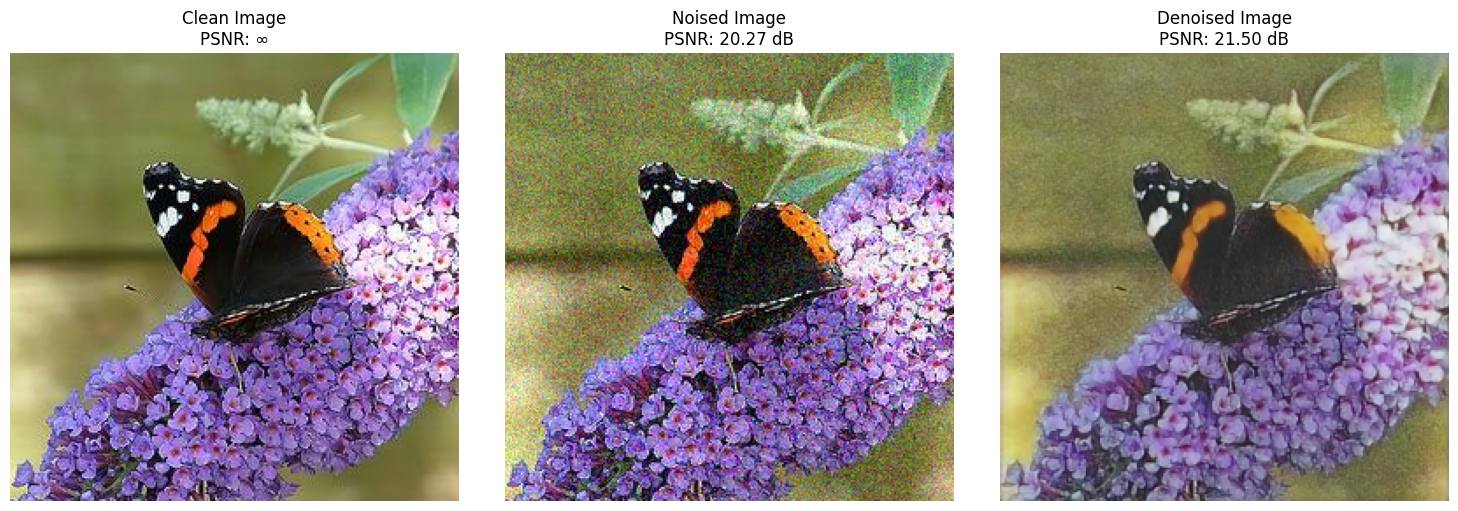

In [17]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
checkpoint = torch.load("checkpoint0.pth", map_location=device)
model.load_state_dict(checkpoint['model'])
model.eval()

transform = T.ToTensor()
inv_transform = T.ToPILImage()

def add_noise(img_tensor, noise_level=0.1):
    noise = torch.randn_like(img_tensor) * noise_level
    return torch.clamp(img_tensor + noise, 0., 1.)

def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(1.0 / math.sqrt(mse.item()))

def average_illumination(img_tensor):
    # Expecting tensor shape: (1, C, H, W)
    return img_tensor.mean().item()

def test_single_image(model, image_path, device):
    img = Image.open(image_path).convert("RGB")
    clean_tensor = transform(img).unsqueeze(0).to(device)
    noisy_tensor = add_noise(clean_tensor)

    with torch.no_grad():
        denoised_tensor = model(noisy_tensor)

    # === Illumination adjustment ===
    illum_clean = average_illumination(clean_tensor)
    illum_denoised = average_illumination(denoised_tensor)

    illum_diff = illum_clean - illum_denoised
    denoised_tensor += illum_diff
    denoised_tensor = torch.clamp(denoised_tensor, 0., 1.)

    # === PSNR ===
    psnr_noisy = calculate_psnr(clean_tensor, noisy_tensor)
    psnr_denoised = calculate_psnr(clean_tensor, denoised_tensor)

    # === Plotting ===
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(inv_transform(clean_tensor.squeeze(0).cpu()))
    axs[0].set_title(f"Clean Image\nPSNR: ∞")
    axs[0].axis("off")

    axs[1].imshow(inv_transform(noisy_tensor.squeeze(0).cpu()))
    axs[1].set_title(f"Noised Image\nPSNR: {psnr_noisy:.2f} dB")
    axs[1].axis("off")

    axs[2].imshow(inv_transform(denoised_tensor.squeeze(0).cpu()))
    axs[2].set_title(f"Denoised Image\nPSNR: {psnr_denoised:.2f} dB")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

# === Run ===
test_single_image(model, "/kaggle/input/aiml-project/491.jpg", device)


In [20]:
import os
import csv
from tqdm import tqdm
from glob import glob

def evaluate_model_on_folder(model, folder_path, device, output_csv='test_psnr.csv'):
    model.eval()
    results = []

    image_paths = sorted(glob(os.path.join(folder_path, "*.*")))  # include all file types
    image_paths = [p for p in image_paths if p.lower().endswith(('.jpg', '.jpeg', '.png'))]


    transform = T.ToTensor()
    
    def add_noise(img_tensor, noise_level=0.1):
        noise = torch.randn_like(img_tensor) * noise_level
        return torch.clamp(img_tensor + noise, 0., 1.)

    def calculate_psnr(img1, img2):
        mse = F.mse_loss(img1, img2)
        if mse == 0:
            return float('inf')
        return 20 * math.log10(1.0 / math.sqrt(mse.item()))

    def average_illumination(img_tensor):
        return img_tensor.mean().item()

    for img_path in tqdm(image_paths, desc="Processing images"):
        img = Image.open(img_path).convert("RGB")
        clean_tensor = transform(img).unsqueeze(0).to(device)
        noisy_tensor = add_noise(clean_tensor)

        with torch.no_grad():
            denoised_tensor = model(noisy_tensor)

        illum_clean = average_illumination(clean_tensor)
        illum_denoised = average_illumination(denoised_tensor)
        illum_diff = illum_clean - illum_denoised

        denoised_tensor += illum_diff
        denoised_tensor = torch.clamp(denoised_tensor, 0., 1.)

        psnr_val = calculate_psnr(clean_tensor, denoised_tensor)
        results.append((os.path.basename(img_path), psnr_val))

    # Save CSV
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Image", "PSNR (dB)"])
        writer.writerows(results)

    # Print average PSNR
    avg_psnr = sum([r[1] for r in results]) / len(results)
    print(f"\nAverage PSNR over {len(results)} images: {avg_psnr:.2f} dB")


In [21]:
evaluate_model_on_folder(model, "/kaggle/input/aiml-project/test_images_50", device)


Processing images: 100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


Average PSNR over 50 images: 24.26 dB


In [23]:
%pip install bm3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.0/862.0 kB 14.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import csv
import numpy as np
from glob import glob
from PIL import Image
import torchvision.transforms as T
from bm3d import bm3d
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from tqdm import tqdm

transform = T.ToTensor()
inv_transform = T.ToPILImage()

def add_noise(img_tensor, noise_level=0.1):
    noise = torch.randn_like(img_tensor) * noise_level
    return torch.clamp(img_tensor + noise, 0., 1.)

def match_brightness(reference, target):
    ref_avg = np.mean(reference)
    tgt_avg = np.mean(target)
    diff = ref_avg - tgt_avg
    adjusted = np.clip(target + diff, 0., 1.)
    return adjusted

def evaluate_bm3d_on_folder(folder_path, output_csv="test_psnr_bm3d_gauss.csv", sigma=25/255.0):
    image_paths = sorted(glob(os.path.join(folder_path, "*.*")))
    image_paths = [p for p in image_paths if p.lower().endswith(('.jpg', '.jpeg', '.png'))]

    results = []

    for path in tqdm(image_paths, desc="Processing with BM3D"):
        # Load image
        img = Image.open(path).convert("RGB")
        clean_tensor = transform(img)
        noisy_tensor = add_noise(clean_tensor)

        # Convert to numpy for BM3D (shape: HWC)
        clean_np = clean_tensor.permute(1, 2, 0).numpy()
        noisy_np = noisy_tensor.permute(1, 2, 0).numpy()

        # Apply BM3D per channel
        denoised_np = np.stack([
            bm3d(noisy_np[:, :, c], sigma_psd=sigma) for c in range(3)
        ], axis=-1)

        # Match brightness
        denoised_np = match_brightness(clean_np, denoised_np)

        # Clip to [0,1]
        denoised_np = np.clip(denoised_np, 0., 1.)

        # PSNR
        psnr_noisy = compare_psnr(clean_np, noisy_np, data_range=1.0)
        psnr_denoised = compare_psnr(clean_np, denoised_np, data_range=1.0)

        filename = os.path.basename(path)
        results.append((filename, psnr_noisy, psnr_denoised))

    # Save to CSV
    with open(output_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Image", "PSNR_Noisy", "PSNR_Denoised_BM3D"])
        writer.writerows(results)

    # Print average PSNR
    avg_psnr = sum([r[2] for r in results]) / len(results)
    print(f"\nAverage BM3D PSNR over {len(results)} images: {avg_psnr:.2f} dB")

# === Call it ===
evaluate_bm3d_on_folder("/kaggle/input/aiml-project/test_images_50")


Processing with BM3D: 100%|██████████| 50/50 [08:20<00:00, 10.00s/it]


Average BM3D PSNR over 50 images: 28.16 dB
